# Reto: Hotel-ID to Combat Human Trafficking 2022

Daniel Salvador Cázares García A01197517

Yoceline Aralí Mata Ledezma A01562116

Yolanda Elizondo Chapa A01137848

Izael Manuel Rascón Durán A01562240

Angel Corrales Sotelo A01562052


# Contexto del reto

Las víctimas de la trata de personas suelen ser fotografiadas en habitaciones de hotel. La identificación de estos hoteles es vital para las investigaciones sobre la trata de personas, pero esto plantea retos particulares debido a la baja calidad de las imágenes y a los ángulos de cámara poco comunes.

Incluso sin víctimas en las imágenes, la identificación de hoteles en general es una tarea de reconocimiento visual difícil, con un gran número de clases y una variación intraclase potencialmente alta y baja entre clases. Para apoyar la investigación de esta difícil tarea y crear herramientas de búsqueda de imágenes para los investigadores de la trata de personas, creamos la aplicación móvil TraffickCam, que permite a los viajeros cotidianos enviar fotos de su habitación de hotel.

En este concurso, los competidores tienen la tarea de identificar el hotel que se ve en las imágenes de prueba del conjunto de datos de TraffickCam, que se basan en una gran galería de imágenes de entrenamiento con identificaciones de hoteles conocidas.

# Imports

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras import models
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
import os, random, shutil
from statistics import mean
from random import sample
from shutil import move

# Sobremuestreo y submuestreo

El problema que se enfrentó al dividir los datos en dos sets es que el número de datos por clase variaba mucho, mientras que algunas carpetas tenían más de 1500 imagenes otras tenían 1. Por lo tanto si se entrenaba el modelo de esta forma, este daría más importancia las clases con más datos. Es por esto que se decidió aplicar algunas técnicas como data oversampling y undersampling para regularizar y balancear las clases. 

**Primer aproximación**:
Si la clase tenía menos de 17 imagenes entonces se realizaba un aumento de datos añadiendo imagenes ligeramente modificadas creadas a partir de las imagenes ya existentes de la clase (Oversampling). Por el contrario si la clase tenía más de 17 imagenes entonces se aplicó  undersampling, en el cual se disminuye las imagenes a un total de 17. 

En resumen se buscó que todas las clases tuvieran 17 imagenes, por lo tanto se reducieron o aumentaron la cantidad necesaria para lograr esto en todas las clases y así lograr un balance entre estas. 

**Segunda aproximación (utilizada)**:
Cuando la clase tenía menos de 12 imágenes esta se elimiaba del conjunto de datos, dejando así solo las clases con más de 11 imáges, a estas se les aplicó sobremuestreo para que el número mínimo de imagenes que pudiera tener una clase fuera 35.

En este caso no se aplicó submuestreo, sin embargo, se utlizaron diferentes pesos para las clases en el momento del entrenamiento, para que no afectara el hecho de que una clase tuviera una mayor cantidad de imágenes que otra.

In [2]:
train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

In [3]:

def data_augmentation(target_number, train_dir, dirName):
  '''
  This function generate new images from the dirName folder in the train_dir
  path until it reach the total number of images equal to target_number.

  Args:
    target_number (int): Number of wished images to be total in the dirName
    train_dir (Path): Path of the dirName folder
    dirName (str): Name of the folder containing the sample images for generate
                  new images.

  Returns: 
    None
  '''

  temp_dir = os.path.join(train_dir, dirName)

  img_names = [os.path.join(temp_dir, name) for name in os.listdir(temp_dir)]
  remainder = sample(img_names, k=target_number % len(img_names))   
  target_per_img = target_number // len(img_names) - 1
  i, j, k = 0, 0, 0

  for img_path in img_names:
      img = tf.keras.preprocessing.image.load_img(img_path)
      img_array = tf.keras.preprocessing.image.img_to_array(img)
      img_array = img_array.reshape((1,) + img_array.shape)

      for batch in train_datagen.flow(img_array, batch_size=1):
          temp = tf.keras.preprocessing.image.array_to_img(batch[0])
          zeros = 9 - len(str(i + 1))
          name = zeros * '0' + str(i + 1)
          name = os.path.join(temp_dir, name + '.jpg')
          temp.save(name)
          i += 1
          if img_path in remainder:
              j += 1
              if j == (target_per_img + 1):
                  j = 0
                  break
          elif img_path not in remainder:
              k += 1
              if k == target_per_img:
                  k = 0
                  break

In [4]:

images_per_folder = 35

def get_target_number(num_images):
  '''
    This function receives the number of images of a class and returns the target number of images the class should have when doing data augmentation.

    Args:
      num_images (int): number of images the class currently has.
    
    Returns: 
      None
  '''
 
  if num_images * 2 <= images_per_folder:
    target_number = images_per_folder
  else:
    target_number = num_images * 2

  return target_number


In [5]:
import time

def oversampling(train_dir, sampleSize, num_images):
  '''
    This function traverse the dataset and applies data augmentation to every class.
  '''
  count_timer = 0
  average = 0

  global count
  for dir in os.listdir(train_dir):
    
    if(num_images[dir] < sampleSize and num_images[dir] > 0):
      t1 = time.time() # empieza
      print(dir, num_images[dir])
      targetNumber = get_target_number(num_images[dir])
      data_augmentation(targetNumber, train_dir, dir)
      count -= 1
      t2 = time.time() # termina

      lasted = t2-t1
      count_timer += 1

      average = (average * (count_timer - 1) + lasted) / count_timer

      estimated_time = average * count


      print("Tiempo estimado: ", estimated_time/60)
      print("Faltan", count)

In [6]:
def subsampling(path, newPath, sampleSize, num_images):
  '''
    Copy all the sub folders with sampleSize number of samples (images) to the
    newPath path. If the number of samples in a subfolder from path is equal to
    the sampleSize, just copy all the samples, if not, takes random samples.

    Args:
      path (Path): Path with the subfolder of the original samples.
      newPath (Path): Path where we want to copy the samples with the sampleSize
      sampleSize (int): Desire number of samples on the new subfolders.
    
    Returns: 
      None
  '''
  global count2 
  for dir in os.listdir(path):
    classPath = os.path.join(path, dir)
    imagesName = os.listdir(classPath)

    newClassPath = os.path.join(newPath, dir)
    num_images = num_images[dir]
    print(dir, num_images[dir])
    if not os.path.exists(newClassPath):
        os.mkdir(newClassPath)
        num = 0
    else:
      num = len(os.listdir(newClassPath))
    
    target = sampleSize - num

    if(num_images >= sampleSize and num < 17):
      sample = random.sample(imagesName, target)

      for fileN in sample:
        shutil.copy(os.path.join(classPath, fileN), newClassPath)

      

# Creating training and validation folders

Para poder comprobar el modelo y descartar un posible overfitting se dividieron los datos proporcionados por Kaggle en dos carpetas. Una para entrenamiento y otra para validación.

In [7]:
proportion = 0.3
base_dir = "dataset2"
train_dir = os.path.join(base_dir,'train_images_balanced')
validation_dir = os.path.join(base_dir, 'validation')

def split_dataset(proportion, train_dir, validation_dir):
  for folder in os.listdir(train_dir):
      path = os.path.join(train_dir, folder)
      new_path = os.path.join(validation_dir, folder)
      os.mkdir(new_path)
      images = [f for f in os.listdir(path)]
      sampled_images = sample(images, k=int(proportion*len(images)))  
      if sampled_images:
          for sampled_image in sampled_images:
              move(os.path.join(path, sampled_image), new_path)

In [8]:
def get_images_per_folder(base_path):

  folders = os.listdir(base_path)
  num_images = {}
  for x in folders:

    num_images[x] = len(os.listdir(os.path.join(base_path, x)))
  
  return num_images

Se puede observar que al crear la subdivisión de carpetas se mantiene el número de clases intactas y lo que varía es la cantidad de datos en cada uno, para el set de entrenamiento se dejo un 70% de los datos y para el de validación el otro 30%.

In [25]:
images_validation = get_images_per_folder("dataset2/validation")
images_training = get_images_per_folder("dataset2/train_images_balanced")

Se asignó un peso distinto a cada clase dependiendo del número de imágenes de estas.

In [12]:
class_weights = {}
folders = os.listdir(train_dir)
for count, folder in enumerate(folders):
    class_weights[count] = 1.0 / images_training[folder]

# Selección del modelo

Para la selección de modelo se eligió entrenar redes neuronales convolucionales con distintas arquitecturas. 

## Transfer Learning

Para el entrenamiento del modelo se utilizó transfer learning con distintas arquitecturas, entre ellas VGG16, VGG19 y Resnet50, de la cual se eligió la que daba mejores resultados, Resnet50

## Arquitectura

La arquitectura que se utilizó fue la siguiente:

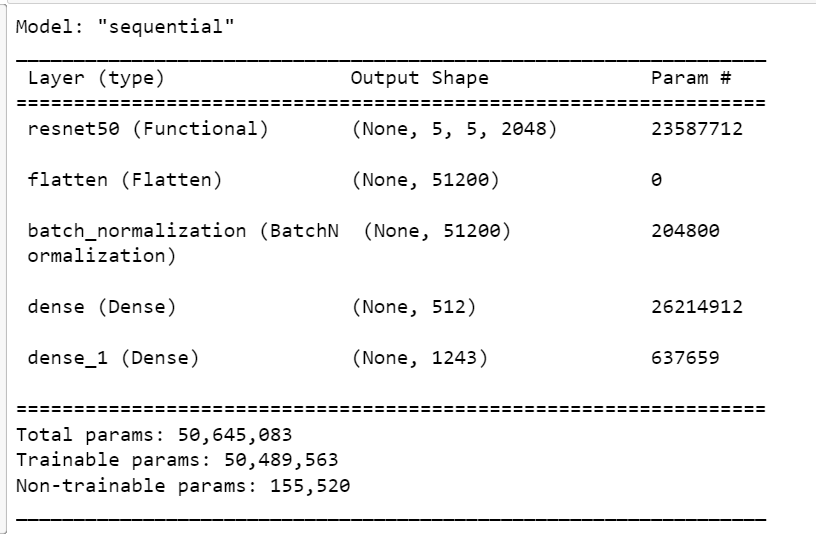

### Sobreajuste

Para reducir el sobreajuste se utilizó una capa de BatchNormalization

## Entrenamiento


In [13]:
train_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size = (150, 150))

validation_datagen  = ImageDataGenerator(rescale=1/255)

validation_generator  = validation_datagen.flow_from_directory(validation_dir,
                                                    target_size = (150, 150))

Found 40259 images belonging to 1243 classes.
Found 16451 images belonging to 1243 classes.


In [14]:
from keras.applications import ResNet50

In [24]:
resnet50_conv_base = ResNet50(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

In [18]:
model = models.Sequential([
                          resnet50_conv_base,
                          Flatten(),
                          BatchNormalization(),
                          Dense(512, activation='relu',kernel_regularizer='l2'), 
                          Dense(1243, activation='softmax')
                          ])

In [19]:
config={
    "learning_rate": 1e-4,
    "epochs": 50,
    "batch_size": 128,
    "steps_per_epoch": 100,
    "validation_steps": 50,
    "validation_batch_size":128,
    "loss_function": "categorical_crossentropy"
}


### Compilación 



In [20]:
model.compile(loss=config["loss_function"], optimizer=tf.keras.optimizers.Adam(learning_rate=config["learning_rate"]), metrics=['acc','top_k_categorical_accuracy'])

### Fit

In [21]:
history = model.fit(train_generator, steps_per_epoch=config["steps_per_epoch"] , epochs=config["epochs"], validation_data=validation_generator, validation_steps=config["validation_steps"])

Epoch 1/50
100/100 [==============================] - 100s 822ms/step - loss: 16.9665 - acc: 0.0422 - top_k_categorical_accuracy: 0.0628 - val_loss: 17.5896 - val_acc: 0.0063 - val_top_k_categorical_accuracy: 0.0088
Epoch 2/50
100/100 [==============================] - 66s 665ms/step - loss: 15.6151 - acc: 0.1403 - top_k_categorical_accuracy: 0.1872 - val_loss: 18.5365 - val_acc: 0.0063 - val_top_k_categorical_accuracy: 0.0181
Epoch 3/50
100/100 [==============================] - 66s 658ms/step - loss: 14.7375 - acc: 0.1450 - top_k_categorical_accuracy: 0.2006 - val_loss: 22.4108 - val_acc: 6.2500e-04 - val_top_k_categorical_accuracy: 0.0069
Epoch 4/50
100/100 [==============================] - 68s 683ms/step - loss: 13.7367 - acc: 0.1955 - top_k_categorical_accuracy: 0.2599 - val_loss: 15.9310 - val_acc: 0.0025 - val_top_k_categorical_accuracy: 0.0162
Epoch 5/50
100/100 [==============================] - 69s 692ms/step - loss: 12.9237 - acc: 0.2275 - top_k_categorical_accuracy: 0.2953

100/100 [==============================] - 69s 689ms/step - loss: 3.3242 - acc: 0.8197 - top_k_categorical_accuracy: 0.9013 - val_loss: 6.0597 - val_acc: 0.3487 - val_top_k_categorical_accuracy: 0.4900
Epoch 40/50
100/100 [==============================] - 69s 686ms/step - loss: 3.2462 - acc: 0.8291 - top_k_categorical_accuracy: 0.9041 - val_loss: 6.0771 - val_acc: 0.3381 - val_top_k_categorical_accuracy: 0.4825
Epoch 41/50
100/100 [==============================] - 68s 684ms/step - loss: 3.2281 - acc: 0.8316 - top_k_categorical_accuracy: 0.9072 - val_loss: 5.9049 - val_acc: 0.3531 - val_top_k_categorical_accuracy: 0.5056
Epoch 42/50
100/100 [==============================] - 68s 679ms/step - loss: 3.1988 - acc: 0.8194 - top_k_categorical_accuracy: 0.9094 - val_loss: 5.8774 - val_acc: 0.3569 - val_top_k_categorical_accuracy: 0.5000
Epoch 43/50
100/100 [==============================] - 69s 691ms/step - loss: 3.1834 - acc: 0.8244 - top_k_categorical_accuracy: 0.9078 - val_loss: 5.8193 -

### Visualización de resultados

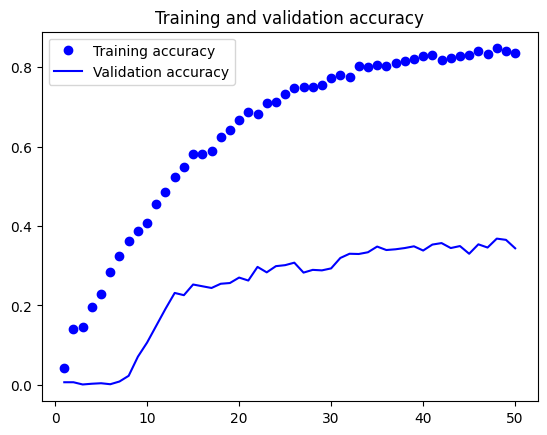

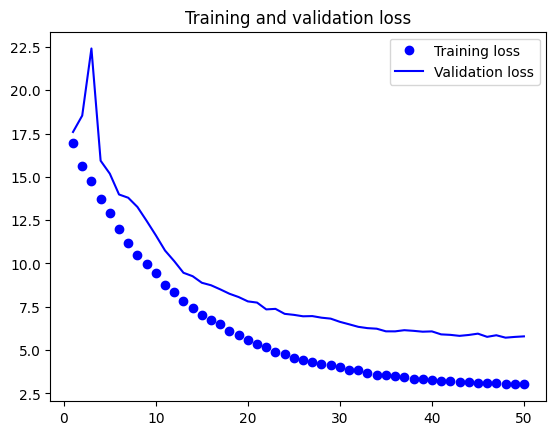

In [22]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

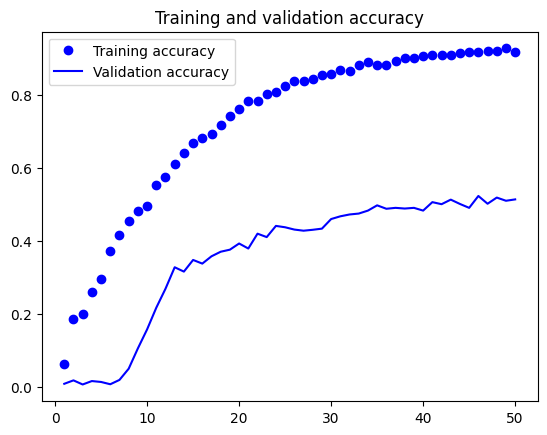

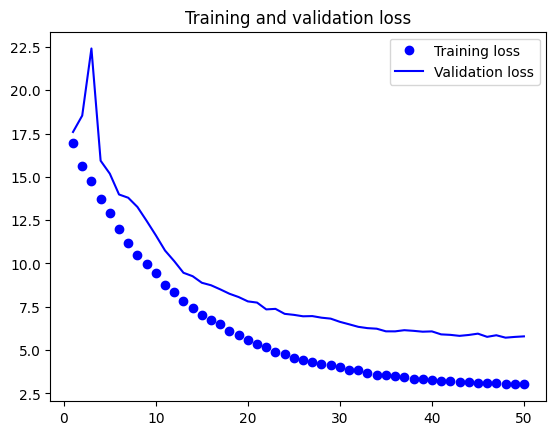

In [23]:
acc = history.history['top_k_categorical_accuracy']
val_acc = history.history['val_top_k_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()